In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [2]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/


In [3]:
cd ../lag-llama

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [5]:
# !pip3 install -r requirements.txt --quiet
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.dataset.repository.datasets import get_dataset

# from gluonts.dataset.pandas import PandasDataset
# from gluonts.dataset.split import split
from gluonts.dataset.common import ListDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_81063/4258175932.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [6]:
# Read data
# ==============================================================================
# data_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/Data'
data_dir = '../Data/spain/four years'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
# df['item_id'] = 'waves'
df.drop(columns = ['period'], inplace = True)
df.head()

# Train-val-test split
# ==============================================================================
# one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = two_months + two_months
end_val = two_months

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()
# df_test = df.iloc[end_train:]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2024-02-19 23:00:00  (n=32208)
Validation dates : 2024-02-20 00:00:00 --- 2024-04-19 23:00:00  (n=1440)
Test dates       : 2024-04-20 00:00:00 --- 2024-06-18 23:00:00  (n=1440)


In [7]:
def create_gluonts_dataset(df, freq, target_column):
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }

    dataset = ListDataset([series], freq=freq)
    return dataset

# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='1H', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='1H', target_column='wave_height')
val = create_gluonts_dataset(df_val, freq='1H', target_column='wave_height')

print('Train dataset:', train)
print('Validation dataset:',val)
print('Test dataset:',test)

[{'start': Period('2020-06-18 00:00', 'H'), 'target': array([0.78, 0.76, 0.74, ..., 1.11, 1.13, 1.16], dtype=float32)}]
[{'start': Period('2024-02-20 00:00', 'H'), 'target': array([1.2 , 1.23, 1.26, ..., 1.39, 1.33, 1.26], dtype=float32)}]
[{'start': Period('2024-04-20 00:00', 'H'), 'target': array([1.2 , 1.15, 1.11, ..., 0.86, 0.84, 0.82], dtype=float32)}]


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [9]:
def get_lag_llama_predictions(dataset,
                                model_ckpt = "lag-llama/lag-llama.ckpt",
                                prediction_length, 
                                context_length=32, 
                                num_samples=20, 
                                device="cpu", 
                                batch_size=1, 
                                nonnegative_pred_samples=True):
    
    
    _device = torch.device(device)
    _ckpt = torch.load(model_ckpt, map_location=_device)
    estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        # ckpt_path="lag-llama.ckpt",
        ckpt_path = model_ckpt,
        prediction_length=prediction_length,
        context_length=context_length,
        device = _device,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module().to(device)
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

    return forecasts, tss

In [12]:
# Forecast parameters
prediction_length = 24
context_length = 32
num_samples = 100
device = torch.device('cpu')

In [13]:
forecasts, tss = get_lag_llama_predictions(
    test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

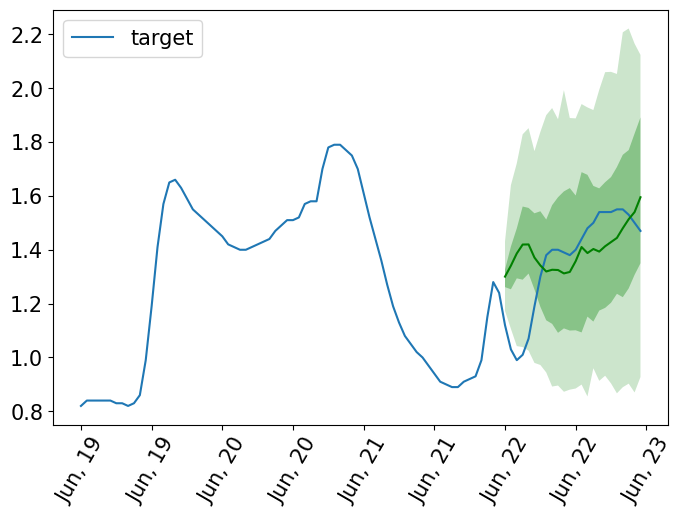

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [17]:
# Recursive multi-step forecasting
# ==============================================================================
context_df = df_train[-48:]
context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

batch_size = 24  # Number of observations per batch
total_length = len(df_test)  # Total length of the target DataFrame

prediction_length = 24
context_length = 32
num_samples = 100
device = torch.device('cpu')

all_point_forecasts = []

# Append batches sequentially to the target DataFrame
for i in range(0, total_length, batch_size):

    # Prediction based on context dataset
    forecasts, tss = get_lag_llama_predictions(
    context_gdf,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
    )

    point_forecast = list(forecasts[0].mean)
    all_point_forecasts.extend(point_forecast)

    # Update context dataset
    batch_start_index = i
    batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
    batch = df_test.iloc[batch_start_index:batch_end_index]
    context_df = pd.concat([context_df, batch], ignore_index=False)
    context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')


Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/72 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/72 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/96 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/96 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/480 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/504 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/504 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/528 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/528 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/552 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/552 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/576 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/576 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/600 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/600 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/624 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/624 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/648 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/648 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/672 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/672 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/696 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/696 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/720 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/720 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/744 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/744 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/768 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/768 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/792 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/792 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/816 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/816 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/840 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/840 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/864 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/864 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/888 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/888 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/912 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/912 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/936 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/936 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/960 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/960 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/984 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/984 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1008 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1008 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1032 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1032 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1056 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1056 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1080 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1080 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1464 [00:00<?, ?it/s]

In [18]:
df_test['forecast'] = all_point_forecasts
df_test

<ipython-input-18-d106bb5005ed>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,wave_height,forecast
datetime,,
2024-04-20 00:00:00,1.20,1.215676
2024-04-20 01:00:00,1.15,1.228464
2024-04-20 02:00:00,1.11,1.387233
2024-04-20 03:00:00,1.08,1.170586
2024-04-20 04:00:00,1.08,1.133618
...,...,...
2024-06-18 19:00:00,0.93,1.346694
2024-06-18 20:00:00,0.92,1.354924
2024-06-18 21:00:00,0.86,1.382985


In [19]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=df_test.index, y=df_test['forecast'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [20]:
metric = mean_absolute_error(df_test['wave_height'], df_test['forecast'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.3875233330267171
